In [1]:
%matplotlib inline

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

from weavingspace.symmetry import Symmetries
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

### Some test polygons

In [2]:
polys = [
  tiling_utils.get_regular_polygon(1000, n = 4),
  tiling_utils.get_regular_polygon(1000, n = 5),
  TileUnit(tiling_type = "hex-dissection", n = 12).tiles.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 6).tiles.geometry[1],
  TileUnit(tiling_type = "hex-dissection", n = 4).tiles.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 3).tiles.geometry[0],
  affine.scale(tiling_utils.get_regular_polygon(1000, n = 3), 0.8, 0.9),
  TileUnit(tiling_type = "cairo", n = 3).tiles.geometry[0],
  affine.scale(tiling_utils.get_regular_polygon(500, 6), 1, 2)]

# translate to centroid (this is to make drawing easier, not required)
polys = [affine.translate(p, -p.centroid.x, -p.centroid.y) for p in polys]

### Find symmetries

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


<Axes: >

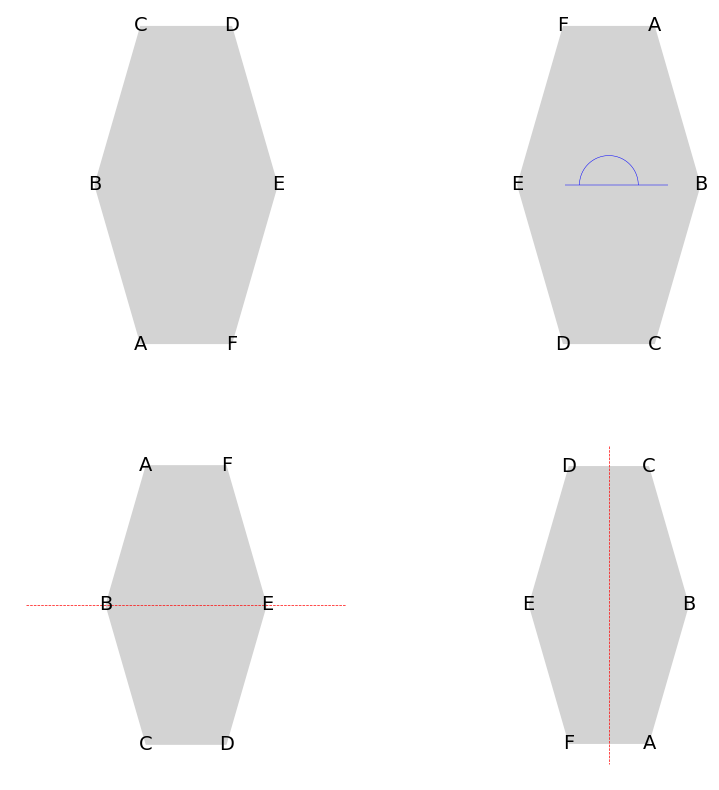

In [3]:
symmetries = Symmetries(polys[8])
symmetries.plot()

<Axes: >

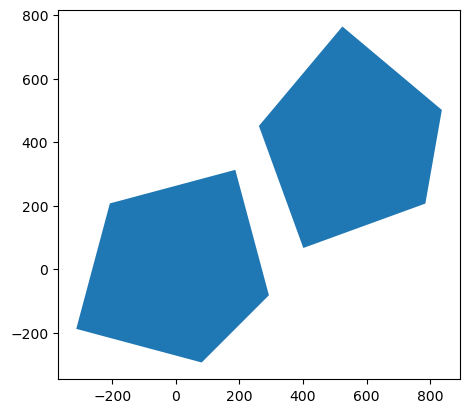

In [4]:
poly = polys[7]
xy = [xy for xy in poly.exterior.coords][:-1]
xy = xy[3:] + xy[:3]
poly_t = geom.Polygon(xy)

poly_t = affine.translate(poly_t, 550, 400)
poly_t = tiling_utils.rotate_preserving_order(poly_t, 35, poly_t.centroid)
gpd.GeoSeries([poly, poly_t]).plot()

In [5]:
s = Symmetries(poly)

In [6]:
tr = s.get_matching_transforms(poly_t)
tr

{'rotation-shifts': [0],
 'reflection-shifts': [2],
 'rotation-angles': [0.0],
 'rotation-transforms': [array([ 1., -0.,  0.,  1.,  0.,  0.])],
 'reflection-angles': [-45.0],
 'reflection-transforms': [array([ 0., -1., -1., -0.,  0.,  0.])],
 'pre-translation': (-549.9999999999998, -399.9999999999998),
 'pre-rotation': -34.99999993666347,
 'pre-transform': [0.819152044923041,
  0.57357643544553,
  -0.57357643544553,
  0.819152044923041,
  -679.9641988858842,
  -12.193778474174815]}

<Axes: >

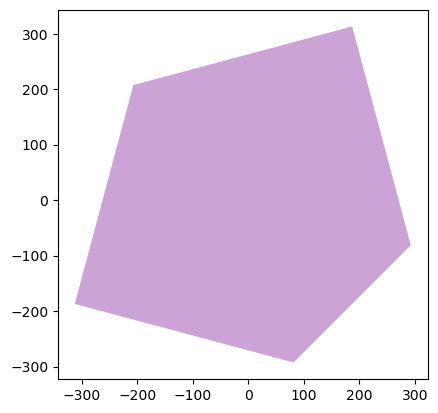

In [7]:
poly_tt = affine.affine_transform(poly_t, tr["pre-transform"])

gpd.GeoSeries([poly, poly_tt]).plot(color = ["r", "b"], alpha = 0.2)

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


<Axes: >

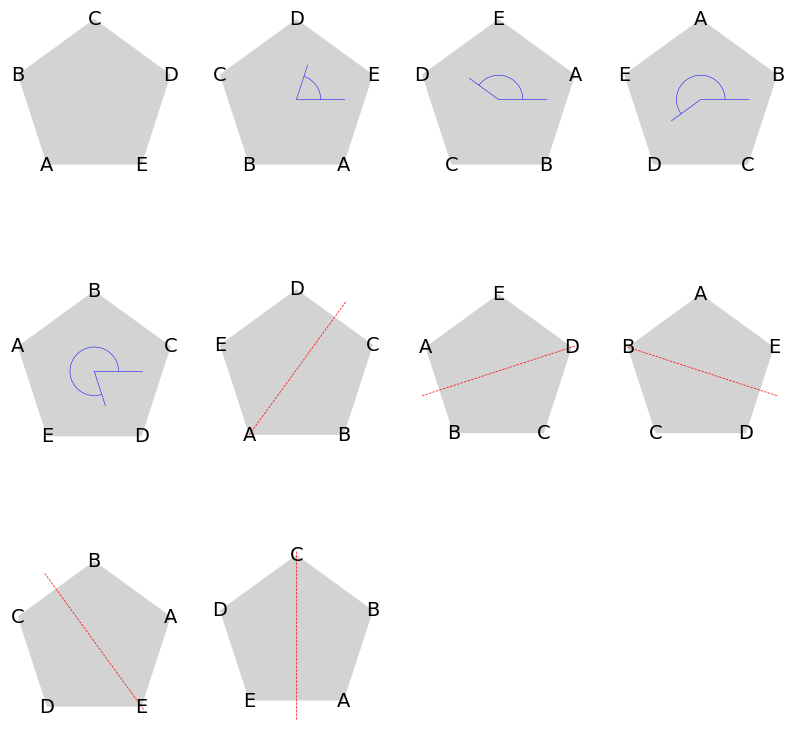

In [8]:
n = 5
p = tiling_utils.get_regular_polygon(1000, n)
s = Symmetries(p)
s.plot()